<a href="https://colab.research.google.com/github/robjmenna/RBE595_deeplearning_final/blob/main/resnet151.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(224, 224, 3)
label: 511
label: convertible


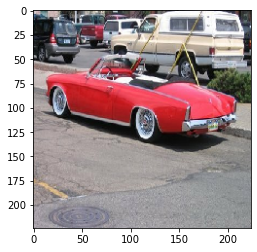

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

def imagenetlabels():
    """Download the list of labels of the imagenet dataset"""
    label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
    blob = requests.get(label_url).text.split('\n')
    labels = [str(line) for line in blob[1:]]
    return labels

data = tfds.load('imagenet2012_subset', data_dir='D:\\tensorflow_datasets')
train = data['train'].map(lambda x: (x['image'], x['label']))
labels = imagenetlabels()
ex = next(train.skip(5).take(1).as_numpy_iterator())
plt.figure()
plt.imshow(ex[0])
print(ex[0].shape)
print('label: ' + labels[ex[1]])

In [28]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

def preprocess(dataset, batch_size, shuffle_buffer_size):
    dataset.map(lambda x: (x['image'], x['label'])
          ).map(lambda x, y: (tf.image.resize(x, [224,224], method='nearest'),y)
          ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y,1000))
          ).shuffle(batch_size
          ).batch(shuffle_buffer_size)

def create_model():
    model = Sequential()
    model.add(Conv2D(256, 3, input_shape=(224,224,3), activation="relu", padding="same"))
    model.add(Conv2D(256, 3, activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 3, activation="relu", padding="same"))
    model.add(Conv2D(128, 3, activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, activation="relu", padding="same"))
    model.add(Conv2D(64, 3, activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dense(500, activation="relu"))
    model.add(Dense(1000, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def create_resnet():
    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4")
    ])
    m.build([None, 224, 224, 3])  # Batch input shape.
    return m

train = preprocess(data['train'], 10, 20)
val = preprocess(data['validation'], 10, 20)

calllist = [TensorBoard('./logs', histogram_freq=1), ModelCheckpoint('./models/facestudent', save_best_only=True)]
model = create_model()
print(model.summary())
batch_size=10
model.fit(train, epochs=10, callbacks=calllist, validation_data=val)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 224, 224, 256)     7168      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 256)     590080    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 128)     295040    
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 56, 56, 64)       

KeyboardInterrupt: 

In [10]:
import tensorflow_hub as hub



10.6 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
